In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# !pip uninstall keras -y
# !pip uninstall keras-nightly -y
# !pip uninstall keras-Preprocessing -y
# !pip uninstall keras-vis -y
# !pip uninstall tensorflow -y

# !pip install tensorflow==2.3.0
# !pip install keras==2.4

In [ ]:
# !pip install tensorflow-ranking

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from IPython.display import SVG
from keras.optimizers import adam_v2
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ndcg_score
from sklearn.metrics import accuracy_score
#import tensorflow_ranking as tfr
from keras.metrics import top_k_categorical_accuracy,MeanAbsoluteError
import numpy as np

In [ ]:
import tensorflow_ranking as tfr

In [ ]:
# Read data
interactions = pd.read_csv("/content/drive/MyDrive/CS646Project/RAW_interactions.csv")

In [ ]:
# Filter required columns
interactions = interactions[['user_id','recipe_id','rating']]

In [ ]:
# Get data dimensions
len(interactions.user_id.unique()), len(interactions.recipe_id.unique())

(226570, 231637)

In [ ]:
interactions.user_id = interactions.user_id.astype('category').cat.codes.values
interactions.recipe_id = interactions.recipe_id.astype('category').cat.codes.values

In [ ]:
interactions.head()

,user_id,recipe_id,rating
0,3935,22741,4
1,99667,22741,5
2,577,24831,4
3,15027,48726,5
4,6799,48726,5


In [ ]:
user_id_dict = {}
k=0
for i in interactions['user_id']:
  if i not in user_id_dict:
    user_id_dict[i] = k
    k+=1

recipe_id_dict = {}
k=0
for i in interactions['recipe_id']:
  if i not in recipe_id_dict:
    recipe_id_dict[i] = k
    k+=1

In [ ]:
# Map current user_id and recipe_id to continuous values, for easier matrix factorization
interactions['user_id_new']= interactions['user_id'].map(user_id_dict)
interactions['recipe_id_new']= interactions['recipe_id'].map(recipe_id_dict)

In [ ]:
# Filter the newly created id columns
df_new = interactions[['user_id_new','recipe_id_new','rating']]

In [ ]:
df = df_new.rename(columns={'user_id_new':'user_id','recipe_id_new':'recipe_id'})

In [ ]:
#df= df.iloc[:200000, :]

In [ ]:
# Setup train and test data
X = df.iloc[:,:2]
Y = df.iloc[:,2]

In [ ]:
# Split data into training and test data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)

In [ ]:
n_users, n_recipes = len(df.user_id.unique()), len(df.recipe_id.unique())

In [ ]:
# No. of latent factors to retrieve
n_latent_factors = 30

In [ ]:
# Embedding setup and model architecture
rec_input = keras.layers.Input(shape=[1],name='Recipe')
#print("rec_input : ",rec_input)
#print("rec_input shape : ", rec_input.shape)
rec_embedding = keras.layers.Embedding(n_recipes + 1, n_latent_factors, name='Recipe-Embedding')(rec_input)
#print("rec_embedding : ",rec_embedding)
#print("rec_embedding shape : ",rec_embedding.shape)
rec_vec = keras.layers.Flatten(name='FlattenRecipes')(rec_embedding)
#print("rec_vec : ",rec_vec)
#print("rec_vec shape : ",rec_vec.shape)

user_input = keras.layers.Input(shape=[1],name='User')
print("user_input shape : ",user_input.shape)
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input)
print("user_embedding shape : ", user_embedding.shape)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)
print("user_vec shape : ",user_vec.shape)
# prod = keras.layers.concatenate([user_vec, rec_vec], name='Concantenate')
# model = keras.Model([user_input, rec_input], prod)
# model.compile('adam', 'mean_squared_error')

user_input shape :  (None, 1)
user_embedding shape :  (None, 1, 30)
user_vec shape :  (None, 30)


In [ ]:
dotted = keras.layers.Dot(name="DotProduct",axes=1)([user_vec, rec_vec])
print(dotted.shape)
model = keras.Model([user_input, rec_input], dotted)
#model.compile('adam', 'mean_squared_error')

# Setup evaluation metrics
eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=False),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=False)
]
optimizer = adam_v2.Adam(learning_rate = 0.01)

model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=[keras.metrics.MeanAbsoluteError(),'top_k_categorical_accuracy',eval_metrics])

(None, 1)


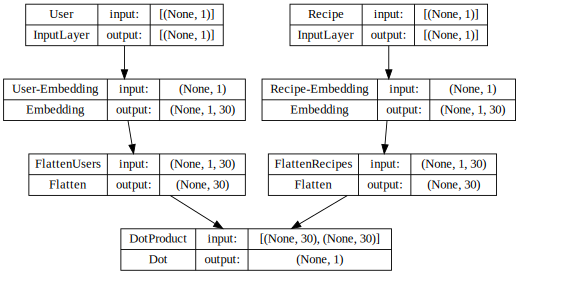

In [ ]:
# Visualize the baseline architecture
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB', dpi=65).create(prog='dot', format='svg'))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Recipe (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 30)        6797130     ['User[0][0]']                   
                                                                                                  
 Recipe-Embedding (Embedding)   (None, 1, 30)        6949140     ['Recipe[0][0]']                 
                                                                                              

In [ ]:
# Train the model
history = model.fit(x=[x_train.user_id, x_train.recipe_id], y=y_train, epochs=10, verbose=2, validation_data=([x_test['user_id'], x_test['recipe_id']], y_test))
#history = model.fit([train.user_id, train.recipe_id], train.rating, epochs=50, verbose=2)

Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
# Plot the values
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()